# Machine Learning Classification (CNN)

**Obiettivo**: Trainare una CNN leggera per classificare le immagini satellitari nelle 4 categorie.

**Dataset**:
- cloudy: 1,500 immagini
- desert: 1,131 immagini
- green_area: 1,500 immagini
- water: 1,500 immagini

**Approccio**:
1. Preparazione dataset: load, resize (64x64), split train/val/test
2. Data augmentation (flip, rotation)
3. Architettura CNN leggera (Conv2D → MaxPool → Dense)
4. Training con early stopping
5. Valutazione: accuracy, confusion matrix, classification report
6. Visualizzazione predizioni su campioni

## 1. Imports

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import random
from typing import Tuple, List

# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.dpi'] = 100

%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("Imports completed successfully")

TensorFlow version: 2.20.0
GPU available: []
Imports completed successfully


## 2. Configuration

In [14]:
# Paths - Auto-detect environment
import sys

DATA_DIR = Path('../data')  # Local relative path
CATEGORIES = ['cloudy', 'desert', 'green_area', 'water']
CLASS_TO_IDX = {cat: idx for idx, cat in enumerate(CATEGORIES)}
IDX_TO_CLASS = {idx: cat for cat, idx in CLASS_TO_IDX.items()}

# Image parameters
IMG_SIZE = (64, 64)
IMG_CHANNELS = 3
NUM_CLASSES = len(CATEGORIES)

# Dataset split
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Training parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data augmentation parameters
AUGMENTATION = {
    'horizontal_flip': True,
    'vertical_flip': True,
    'rotation_range': 20,
    'zoom_range': 0.1,
}

print(f"Data directory: {DATA_DIR.absolute()}")
print(f"Categories: {CATEGORIES}")
print(f"Image size: {IMG_SIZE}")
print(f"Dataset split: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")
print(f"Batch size: {BATCH_SIZE}, Epochs: {EPOCHS}")

Data directory: /Users/aldojacopo/forme-idee/notebooks/../data
Categories: ['cloudy', 'desert', 'green_area', 'water']
Image size: (64, 64)
Dataset split: Train=0.7, Val=0.15, Test=0.15
Batch size: 32, Epochs: 50


## 3. Data Loading

In [15]:
def load_dataset() -> Tuple[np.ndarray, np.ndarray]:
    """
    Load all images from the dataset.
    
    Returns:
        Tuple of (images, labels)
        - images: (N, H, W, 3) numpy array
        - labels: (N,) numpy array with class indices
    """
    all_images = []
    all_labels = []
    
    for category in CATEGORIES:
        category_path = DATA_DIR / category
        image_files = list(category_path.glob('*.jpg'))
        label = CLASS_TO_IDX[category]
        
        print(f"Loading {category}: {len(image_files)} images...")
        
        for img_path in image_files:
            # Load and resize
            img = Image.open(img_path).convert('RGB')
            img_resized = img.resize(IMG_SIZE, Image.LANCZOS)
            img_array = np.array(img_resized)
            
            all_images.append(img_array)
            all_labels.append(label)
    
    # Convert to numpy arrays
    images = np.array(all_images, dtype=np.float32)
    labels = np.array(all_labels, dtype=np.int32)
    
    # Normalize images to [0, 1]
    images = images / 255.0
    
    return images, labels


# Load dataset
print("Loading dataset...\n")
X, y = load_dataset()

print(f"\nDataset loaded:")
print(f"  Images shape: {X.shape}")
print(f"  Labels shape: {y.shape}")

# Check if dataset is empty
if len(X) > 0:
    print(f"  Image range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"  Total samples: {len(X)}")

    # Class distribution
    print("\nClass distribution:")
    for idx, category in IDX_TO_CLASS.items():
        count = np.sum(y == idx)
        percentage = (count / len(y)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")
else:
    print("ERROR: No images loaded! Check DATA_DIR path.")
    print(f"  Current DATA_DIR: {DATA_DIR.absolute()}")
    print(f"  Expected structure: {DATA_DIR}/cloudy/, {DATA_DIR}/desert/, etc.")

Loading dataset...

Loading cloudy: 1500 images...
Loading desert: 1131 images...
Loading green_area: 1500 images...
Loading water: 1500 images...

Dataset loaded:
  Images shape: (5631, 64, 64, 3)
  Labels shape: (5631,)
  Image range: [0.016, 1.000]
  Total samples: 5631

Class distribution:
  cloudy: 1500 (26.6%)
  desert: 1131 (20.1%)
  green_area: 1500 (26.6%)
  water: 1500 (26.6%)


## 4. Train/Val/Test Split

In [16]:
# Skip this cell if no data was loaded
if len(X) == 0:
    print("CANNOT PROCEED: No dataset loaded!")
    print("Please ensure images are in the correct directory:")
    print(f"  {DATA_DIR.absolute()}/cloudy/")
    print(f"  {DATA_DIR.absolute()}/desert/")
    print(f"  {DATA_DIR.absolute()}/green_area/")
    print(f"  {DATA_DIR.absolute()}/water/")
    print("\nIf running in Colab, you need to upload the data folder first.")
    raise SystemExit("Stopping execution due to missing data.")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=TEST_RATIO, 
    stratify=y,
    random_state=42
)

# Second split: separate train and validation
val_size_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    stratify=y_temp,
    random_state=42
)

print("Dataset split:")
print(f"  Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Val:   {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify stratification
print("\nClass distribution in splits:")
for idx, category in IDX_TO_CLASS.items():
    train_count = np.sum(y_train == idx)
    val_count = np.sum(y_val == idx)
    test_count = np.sum(y_test == idx)
    print(f"  {category}: Train={train_count}, Val={val_count}, Test={test_count}")

Dataset split:
  Train: 3941 samples (70.0%)
  Val:   845 samples (15.0%)
  Test:  845 samples (15.0%)

Class distribution in splits:
  cloudy: Train=1050, Val=225, Test=225
  desert: Train=791, Val=170, Test=170
  green_area: Train=1050, Val=225, Test=225
  water: Train=1050, Val=225, Test=225


## 5. Data Augmentation

In [17]:
# Create data generator with augmentation for training
train_datagen = ImageDataGenerator(
    horizontal_flip=AUGMENTATION['horizontal_flip'],
    vertical_flip=AUGMENTATION['vertical_flip'],
    rotation_range=AUGMENTATION['rotation_range'],
    zoom_range=AUGMENTATION['zoom_range'],
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator()

print("Data augmentation configured:")
print(f"  Horizontal flip: {AUGMENTATION['horizontal_flip']}")
print(f"  Vertical flip: {AUGMENTATION['vertical_flip']}")
print(f"  Rotation range: ±{AUGMENTATION['rotation_range']}°")
print(f"  Zoom range: {AUGMENTATION['zoom_range']}")

Data augmentation configured:
  Horizontal flip: True
  Vertical flip: True
  Rotation range: ±20°
  Zoom range: 0.1


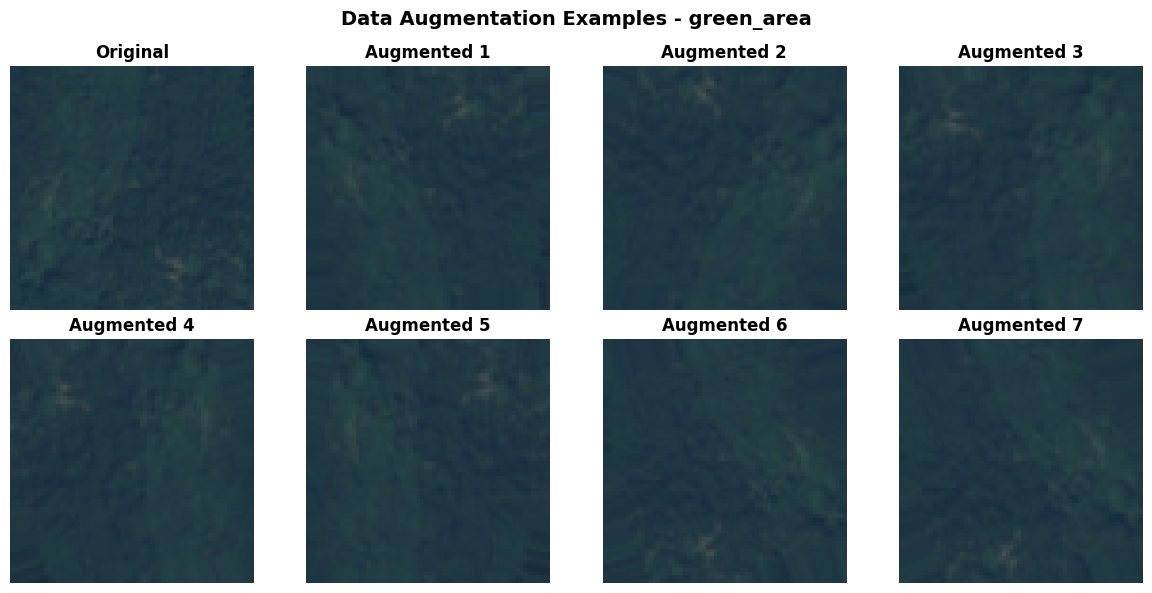

In [18]:
# Visualize augmented samples
sample_img = X_train[0:1]  # Take first image
sample_label = y_train[0]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Original
axes[0].imshow(sample_img[0])
axes[0].set_title('Original', fontweight='bold')
axes[0].axis('off')

# Augmented versions
aug_iter = train_datagen.flow(sample_img, batch_size=1, seed=42)
for i in range(1, 8):
    aug_img = next(aug_iter)[0]
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Augmented {i}', fontweight='bold')
    axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples - {IDX_TO_CLASS[sample_label]}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Model Architecture

In [19]:
def create_cnn_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """
    Create a lightweight CNN for image classification.
    
    Architecture:
    - 3 Convolutional blocks (Conv2D → BatchNorm → MaxPool → Dropout)
    - Global Average Pooling
    - Dense layers with dropout
    - Softmax output
    
    Args:
        input_shape: (H, W, C) input image shape
        num_classes: Number of output classes
    
    Returns:
        Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global pooling
        layers.GlobalAveragePooling2D(),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model


# Create model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
model = create_cnn_model(input_shape, NUM_CLASSES)

# Display architecture
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,684 (467.52 KB)

 Trainable params: 118,980 (464.77 KB)

 Non-trainable params: 704 (2.75 KB)


Total parameters: 119,684


## 7. Compile Model

In [20]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Model compiled:")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: sparse_categorical_crossentropy")
print(f"  Metrics: accuracy")

Model compiled:
  Optimizer: Adam (lr=0.001)
  Loss: sparse_categorical_crossentropy
  Metrics: accuracy


## 8. Callbacks

In [21]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("Callbacks configured:")
print("  - Early stopping (patience=10)")
print("  - Learning rate reduction (patience=5, factor=0.5)")

Callbacks configured:
  - Early stopping (patience=10)
  - Learning rate reduction (patience=5, factor=0.5)


## 9. Training

In [22]:
print(f"Starting training for {EPOCHS} epochs...\n")

# Train model with data augmentation
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")

Starting training for 50 epochs...

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.7666 - loss: 0.5923 - val_accuracy: 0.2663 - val_loss: 1.8561 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8480 - loss: 0.3959 - val_accuracy: 0.2663 - val_loss: 3.8100 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.8675 - loss: 0.3362 - val_accuracy: 0.2663 - val_loss: 4.1744 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.8777 - loss: 0.3346 - val_accuracy: 0.6107 - val_loss: 1.5834 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.8891 - loss: 0.2926 - val_accuracy: 0.7420 - val_loss: 0.6273 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9066 - loss: 0.2671 - val_accuracy: 0.6118 - val_loss: 1.7942 - learning_rate: 0.0010
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━

## 10. Training History Visualization

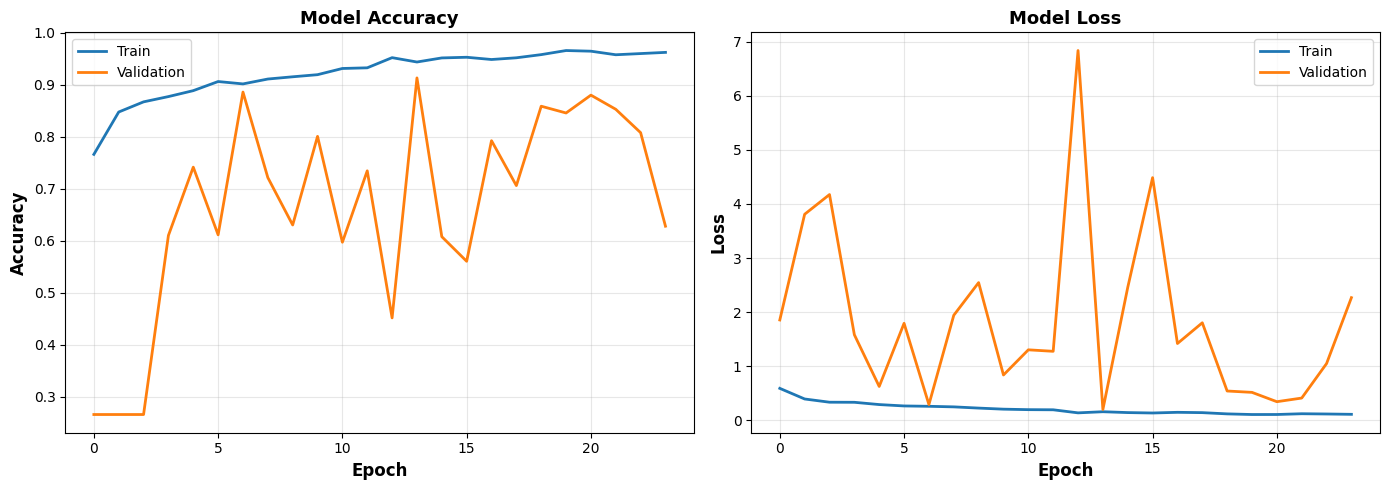


Final Training Metrics:
  Train Accuracy: 0.9627
  Train Loss:     0.1123
  Val Accuracy:   0.6284
  Val Loss:       2.2687


In [23]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Model Accuracy', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Model Loss', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\nFinal Training Metrics:")
print(f"  Train Accuracy: {final_train_acc:.4f}")
print(f"  Train Loss:     {final_train_loss:.4f}")
print(f"  Val Accuracy:   {final_val_acc:.4f}")
print(f"  Val Loss:       {final_val_loss:.4f}")

## 11. Evaluation on Test Set

In [24]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("="*70)
print("TEST SET EVALUATION")
print("="*70)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss:     {test_loss:.4f}")
print("="*70)

TEST SET EVALUATION
Test Accuracy: 0.9136 (91.36%)
Test Loss:     0.1988


## 12. Confusion Matrix

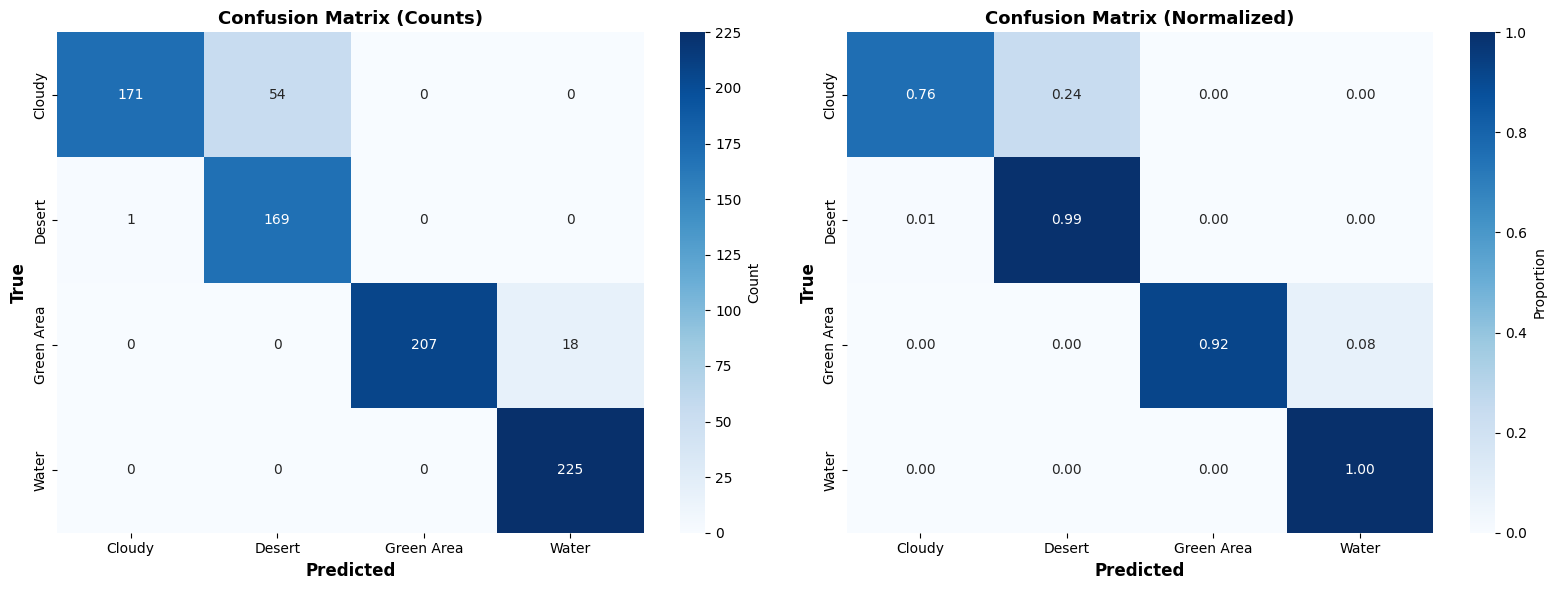

In [25]:
# Generate predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[cat.replace('_', ' ').title() for cat in CATEGORIES],
            yticklabels=[cat.replace('_', ' ').title() for cat in CATEGORIES],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13, fontweight='bold')

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=[cat.replace('_', ' ').title() for cat in CATEGORIES],
            yticklabels=[cat.replace('_', ' ').title() for cat in CATEGORIES],
            ax=axes[1], cbar_kws={'label': 'Proportion'})
axes[1].set_xlabel('Predicted', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Classification Report

In [26]:
# Generate classification report
target_names = [cat.replace('_', ' ').title() for cat in CATEGORIES]
report = classification_report(y_test, y_pred, target_names=target_names)

print("="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(report)
print("="*70)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Cloudy       0.99      0.76      0.86       225
      Desert       0.76      0.99      0.86       170
  Green Area       1.00      0.92      0.96       225
       Water       0.93      1.00      0.96       225

    accuracy                           0.91       845
   macro avg       0.92      0.92      0.91       845
weighted avg       0.93      0.91      0.91       845



## 14. Per-Class Accuracy

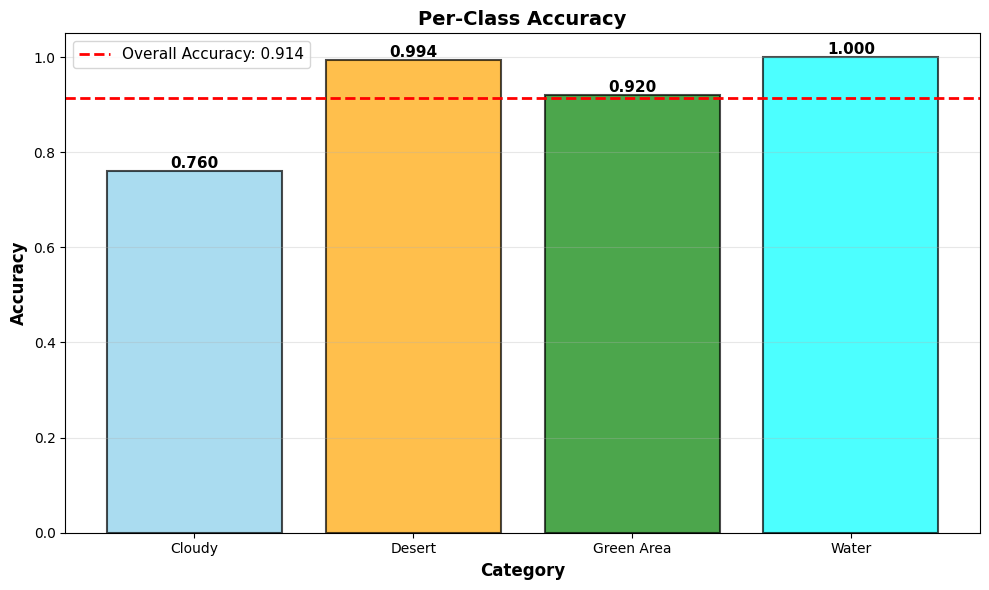


Per-Class Accuracy:
  Cloudy: 0.7600
  Desert: 0.9941
  Green Area: 0.9200
  Water: 1.0000


In [27]:
# Calculate per-class accuracy
per_class_acc = cm_normalized.diagonal()

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(CATEGORIES))
bars = ax.bar(x, per_class_acc, alpha=0.7,
              color=['skyblue', 'orange', 'green', 'cyan'],
              edgecolor='black', linewidth=1.5)

ax.set_xlabel('Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in CATEGORIES])
ax.set_ylim([0, 1.05])
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=test_accuracy, color='red', linestyle='--', linewidth=2, 
           label=f'Overall Accuracy: {test_accuracy:.3f}')

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, per_class_acc)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
for i, category in enumerate(CATEGORIES):
    print(f"  {category.replace('_', ' ').title()}: {per_class_acc[i]:.4f}")

## 15. Sample Predictions Visualization

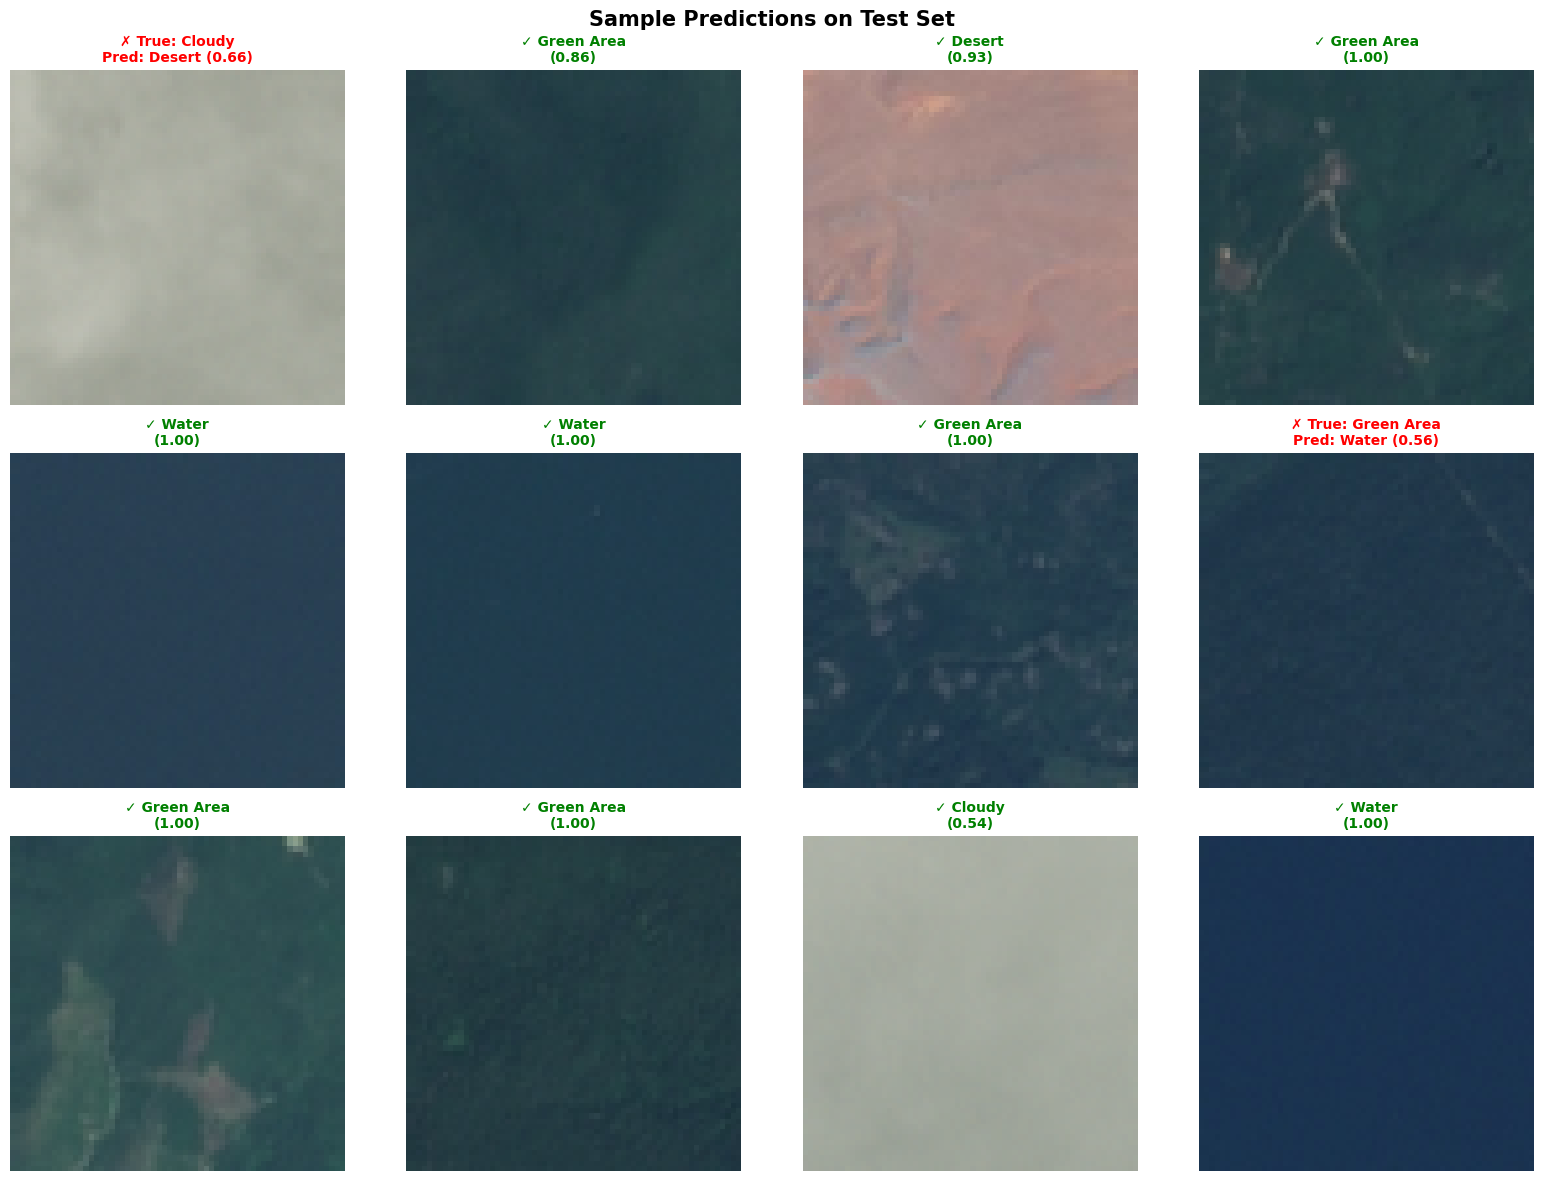

In [28]:
# Select random samples from test set
n_samples = 12
random_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]
    pred_prob = y_pred_probs[idx][pred_label]
    
    # Plot image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Title with true and predicted labels
    true_name = IDX_TO_CLASS[true_label].replace('_', ' ').title()
    pred_name = IDX_TO_CLASS[pred_label].replace('_', ' ').title()
    
    if true_label == pred_label:
        color = 'green'
        title = f'✓ {true_name}\n({pred_prob:.2f})'
    else:
        color = 'red'
        title = f'✗ True: {true_name}\nPred: {pred_name} ({pred_prob:.2f})'
    
    axes[i].set_title(title, fontsize=10, fontweight='bold', color=color)

plt.suptitle('Sample Predictions on Test Set', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

## 16. Misclassification Analysis

Number of misclassifications: 73 / 845
Misclassification rate: 8.64%


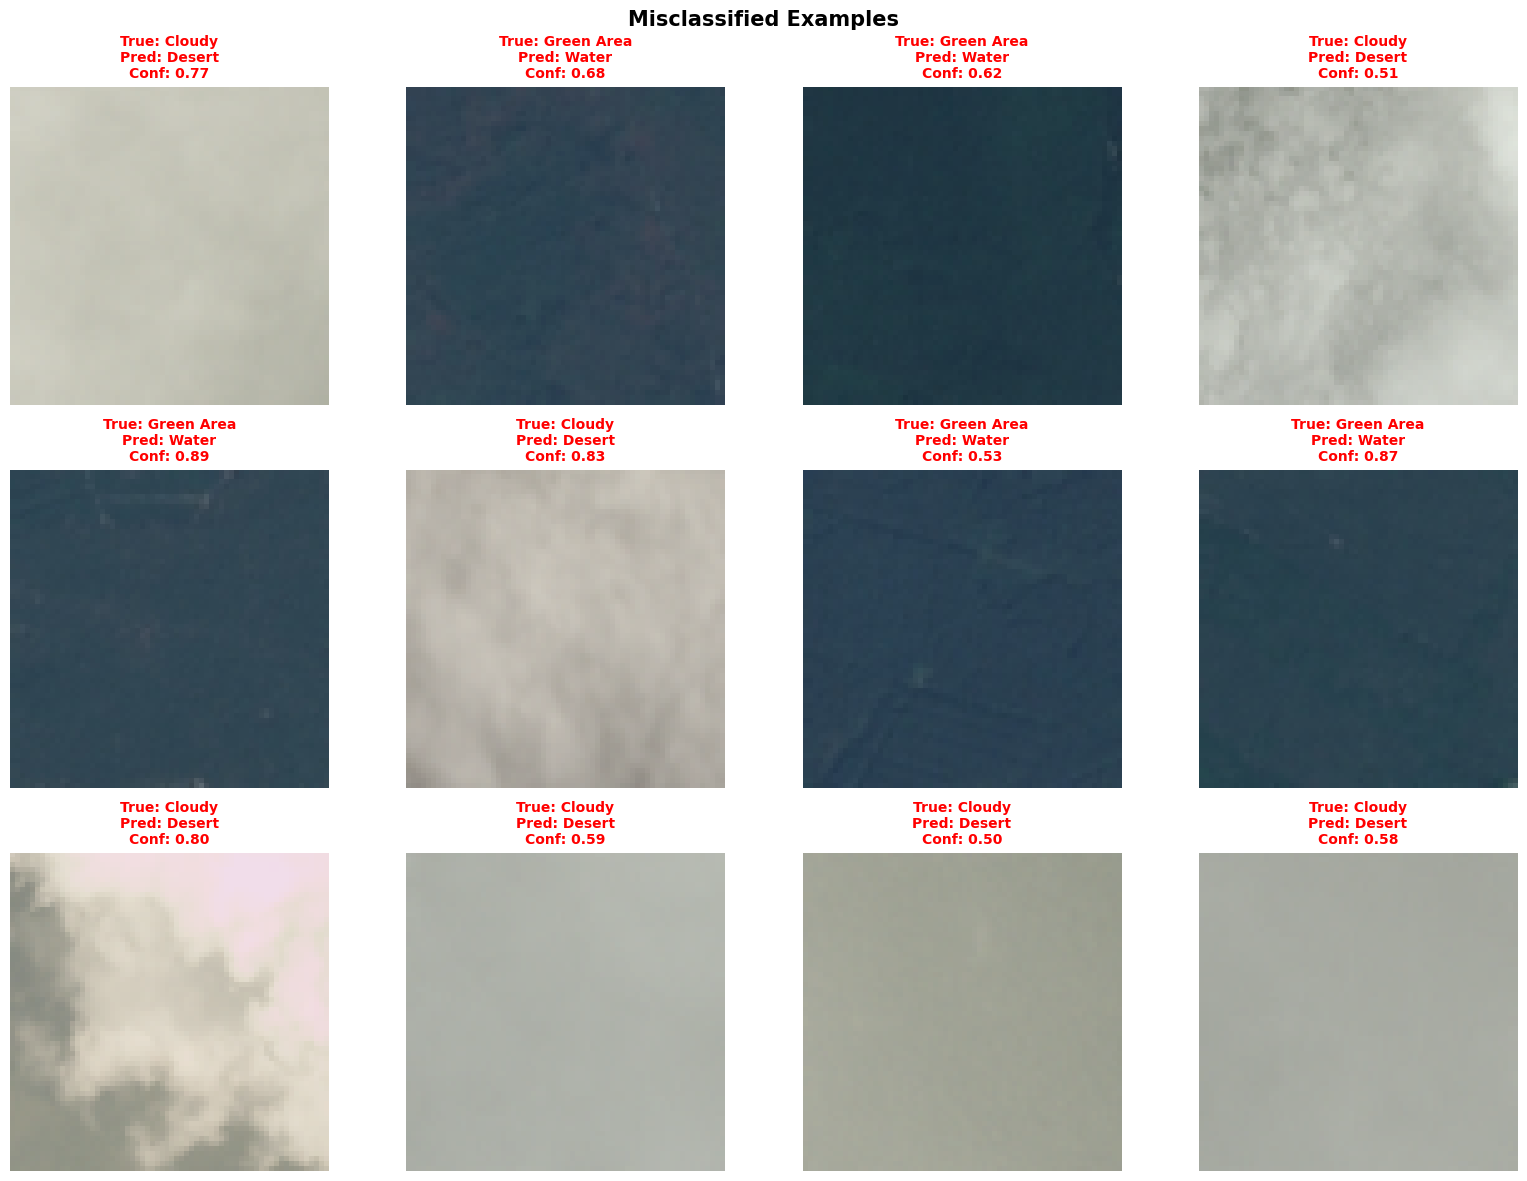

In [29]:
# Find misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]
n_misclassified = len(misclassified_indices)

print(f"Number of misclassifications: {n_misclassified} / {len(y_test)}")
print(f"Misclassification rate: {n_misclassified/len(y_test)*100:.2f}%")

if n_misclassified > 0:
    # Show some misclassified examples
    n_show = min(12, n_misclassified)
    show_indices = np.random.choice(misclassified_indices, n_show, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(show_indices):
        img = X_test[idx]
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        pred_prob = y_pred_probs[idx][pred_label]
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        true_name = IDX_TO_CLASS[true_label].replace('_', ' ').title()
        pred_name = IDX_TO_CLASS[pred_label].replace('_', ' ').title()
        
        title = f'True: {true_name}\nPred: {pred_name}\nConf: {pred_prob:.2f}'
        axes[i].set_title(title, fontsize=10, fontweight='bold', color='red')
    
    # Hide extra subplots
    for i in range(n_show, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Misclassified Examples', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 17. Summary

In [30]:
print("\n" + "="*70)
print("MACHINE LEARNING CLASSIFICATION - SUMMARY")
print("="*70)

print("\nModel Architecture:")
print("  - 3 Convolutional blocks (Conv2D → BatchNorm → MaxPool → Dropout)")
print("  - Global Average Pooling")
print("  - 2 Dense layers with dropout")
print(f"  - Total parameters: {total_params:,}")

print("\nTraining Configuration:")
print(f"  - Dataset: {len(X)} images ({NUM_CLASSES} classes)")
print(f"  - Train/Val/Test split: {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")
print(f"  - Image size: {IMG_SIZE}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs trained: {len(history.history['loss'])}")
print(f"  - Data augmentation: Yes (flip, rotation, zoom)")

print("\nPerformance:")
print(f"  - Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Test Loss:      {test_loss:.4f}")

print("\nPer-Class Accuracy:")
for i, category in enumerate(CATEGORIES):
    print(f"  - {category.replace('_', ' ').title()}: {per_class_acc[i]:.4f}")

print("\nMisclassifications:")
print(f"  - Total: {n_misclassified} / {len(y_test)}")
print(f"  - Rate: {n_misclassified/len(y_test)*100:.2f}%")

print("\nKey Insights:")
if test_accuracy > 0.85:
    print("  ✓ Excellent performance (>85% accuracy)")
elif test_accuracy > 0.75:
    print("  ✓ Good performance (75-85% accuracy)")
else:
    print("  ⚠ Room for improvement (<75% accuracy)")

best_class = CATEGORIES[np.argmax(per_class_acc)]
worst_class = CATEGORIES[np.argmin(per_class_acc)]
print(f"  - Best class: {best_class.replace('_', ' ').title()} "
      f"({per_class_acc[np.argmax(per_class_acc)]:.3f})")
print(f"  - Worst class: {worst_class.replace('_', ' ').title()} "
      f"({per_class_acc[np.argmin(per_class_acc)]:.3f})")

print("\n" + "="*70)
print("✓ ML classification completed")
print("  Next step: Comparison dashboard (07_comparison_dashboard.ipynb)")
print("="*70)


MACHINE LEARNING CLASSIFICATION - SUMMARY

Model Architecture:
  - 3 Convolutional blocks (Conv2D → BatchNorm → MaxPool → Dropout)
  - Global Average Pooling
  - 2 Dense layers with dropout
  - Total parameters: 119,684

Training Configuration:
  - Dataset: 5631 images (4 classes)
  - Train/Val/Test split: 0.7/0.15/0.15
  - Image size: (64, 64)
  - Batch size: 32
  - Epochs trained: 24
  - Data augmentation: Yes (flip, rotation, zoom)

Performance:
  - Test Accuracy:  0.9136 (91.36%)
  - Test Loss:      0.1988

Per-Class Accuracy:
  - Cloudy: 0.7600
  - Desert: 0.9941
  - Green Area: 0.9200
  - Water: 1.0000

Misclassifications:
  - Total: 73 / 845
  - Rate: 8.64%

Key Insights:
  ✓ Excellent performance (>85% accuracy)
  - Best class: Water (1.000)
  - Worst class: Cloudy (0.760)

✓ ML classification completed
  Next step: Comparison dashboard (07_comparison_dashboard.ipynb)
